In [17]:
import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import ParabolaGen
import NoiseGen
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [4]:
x_dim = 92
y_dim = 120
time_dimension = 1000
num_of_files = 1
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)

train_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 128, origin).unsqueeze(1)
test_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 32, origin).unsqueeze(1)

train_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(128, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(128, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + train_data, 0, 1)
test_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(32, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(32, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + test_data, 0, 1)

In [5]:
train_data.shape

torch.Size([128, 1, 120, 92])

Text(0.5, 1.0, 'Noisy Image')

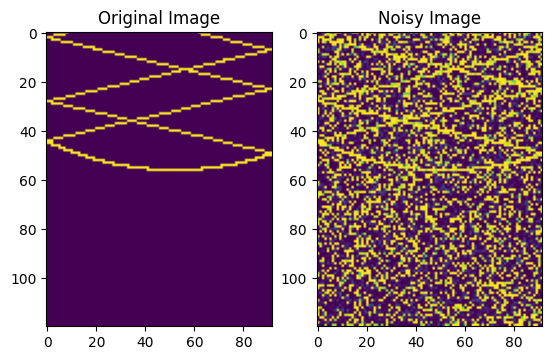

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data_noisy[0][0])

ax[0].set_title("Original Image")
ax[1].set_title("Noisy Image")

In [7]:
class LinearAutoencoder(beacon.Module):
    def __init__(self, input_features):
        super().__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU()
        )
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, input_features),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
model = LinearAutoencoder(x_dim * y_dim).to(device)

In [9]:
summary(model, (1, x_dim * y_dim))

Layer (type:depth-idx)                   Output Shape              Param #
LinearAutoencoder                        [1, 11040]                --
├─Sequential: 1-1                        [1, 16]                   --
│    └─Linear: 2-1                       [1, 128]                  1,413,248
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Dropout: 2-3                      [1, 128]                  --
│    └─Linear: 2-4                       [1, 16]                   2,064
│    └─ReLU: 2-5                         [1, 16]                   --
├─Sequential: 1-2                        [1, 11040]                --
│    └─Linear: 2-6                       [1, 128]                  2,176
│    └─ReLU: 2-7                         [1, 128]                  --
│    └─Dropout: 2-8                      [1, 128]                  --
│    └─Linear: 2-9                       [1, 11040]                1,424,160
Total params: 2,841,648
Trainable params: 2,841,648
Non-trainable

In [10]:
autoencoder = LinearAutoencoder(x_dim * y_dim).to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [11]:
for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.view(-1, x_dim * y_dim).to(device))
    loss = loss_function(outputs, train_data.view(-1, x_dim * y_dim).to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 100/100 [00:00<00:00, 163.45it/s]


In [12]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder(test_data_noisy.view(-1, x_dim * y_dim).to(device))
    test_loss = loss_function(pred, test_data.view(-1, x_dim * y_dim).to(device))
    print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0496


Text(0.5, 0.98, 'Linear Autoencoder')

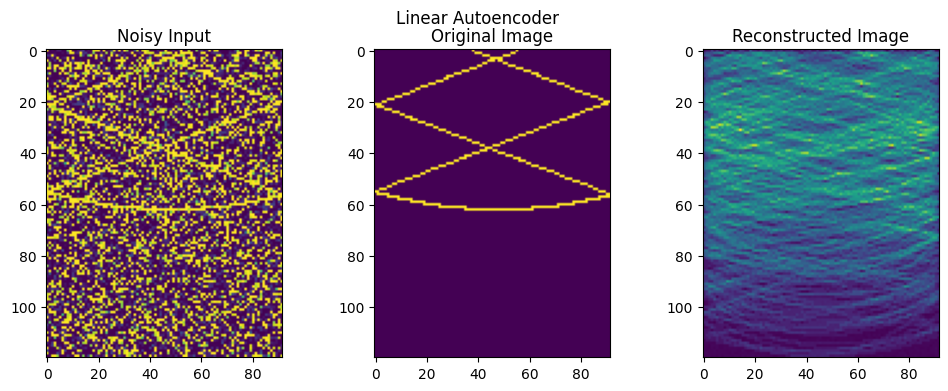

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0])
ax[1].imshow(test_data[0][0])
ax[2].imshow(pred[0].view(y_dim, x_dim).cpu().numpy())

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

plt.suptitle("Linear Autoencoder")

In [14]:
pred[0].max() /2

tensor(0.0889, device='cuda:0')

In [15]:
# refine pred to be binary
pred_max = pred.max()
pred_min = pred.min()
pred = (pred - pred_min) / (pred_max - pred_min)
pred_binary = torch.where(pred > 0.5, 1, 0)

Text(0.5, 0.98, 'Linear Autoencoder')

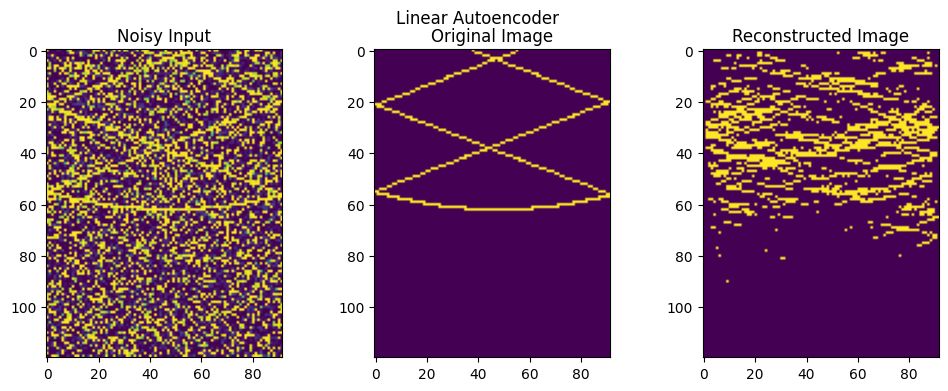

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0])
ax[1].imshow(test_data[0][0])
ax[2].imshow(pred_binary[0].view(y_dim, x_dim).cpu().numpy())

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

plt.suptitle("Linear Autoencoder")

In [74]:
# measure the percentage of false-positive, false-negative, true-positive, true-negative
# measure the accuracy

original_img = test_data[0][0]
reconstructed_img = pred_binary[0].view(y_dim, x_dim).cpu()

original_img = original_img.unsqueeze(-1)
reconstructed_img = reconstructed_img.unsqueeze(-1)

false_positive = torch.sum((reconstructed_img == 1) & (original_img == 0)).item()
false_negative = torch.sum((reconstructed_img == 0) & (original_img == 1)).item()
true_positive = torch.sum((reconstructed_img == 1) & (original_img == 1)).item()
true_negative = torch.sum((reconstructed_img == 0) & (original_img == 0)).item()

print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")
print(f"True Positive: {true_positive}")
print(f"True Negative: {true_negative}")

false_positive_rate = false_positive / (false_positive + true_negative)
print(f"False Positive Rate: {false_positive_rate}")
false_negative_rate = false_negative / (false_negative + true_positive)
print(f"False Negative Rate: {false_negative_rate}")
senstivity = true_positive / (true_positive + false_negative)
print(f"Sensitivity: {senstivity}")
specificity = true_negative / (true_negative + false_positive)
print(f"Specificity: {specificity}")
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy}")

False Positive: 1421
False Negative: 176
True Positive: 55
True Negative: 9388
False Positive Rate: 0.13146452030715144
False Negative Rate: 0.7619047619047619
Sensitivity: 0.23809523809523808
Specificity: 0.8685354796928485
Accuracy: 0.8553442028985507


In [22]:
roc_auc = roc_auc_score(test_data[0][0].flatten().numpy(), pred_binary[0].cpu().numpy())
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.5461738430505405


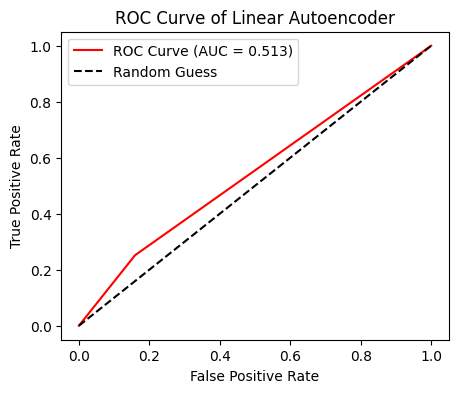

In [30]:
fpr, tpr, thresholds = roc_curve(test_data[0][0].flatten().numpy(), pred_binary[0].cpu().numpy())
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = 0.513)", color="red")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Linear Autoencoder")
plt.legend(loc="best")
plt.show()